Histograms and scatter plots for a Mante full-rank network for fig 1.

In [2]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
from low_rank_rnns import mante, helpers, regressions, clustering
import low_rank_rnns.mixedselectivity as ms
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse

In [3]:
helpers.setup_matplotlib()
color = sns.color_palette('deep')[3]

In [4]:
hidden_size = 512
noise_std = 0
alpha = 0.2

x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_lr_fig1.pt', map_location='cpu'))
loss_orig, acc_orig = mante.test_mante(net, x_val, y_val, mask_val)
print(acc_orig)

1.0


In [5]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()

# Positivity adjustments
n = -n
m = -m

(500, 512)
clusteriness: 1.8876202527001145
data mean: 0.334, mc mean: 0.456
KS 2 sample test: p=4.2580603545681916e-151
Wilcoxon rank-sum test: p=8.405579580836887e-142
Kruskal-Wallis test: p=8.405577099390443e-142


(8.405579580836887e-142, 1.8876202527001145)

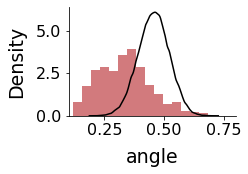

In [6]:
figsize = plt.rcParams['figure.figsize']
figsize = (figsize[0] / 2, figsize[1] / 2)
conn_space = np.stack([m, n, wi1, wi2, wi_ctx1, wi_ctx2]).T
ms.epairs(conn_space, 500, figsize=figsize, xlim=(.1, .8), col=color)
# plt.savefig('figure_1/epairs_mante.pdf', bbox_inches='tight')

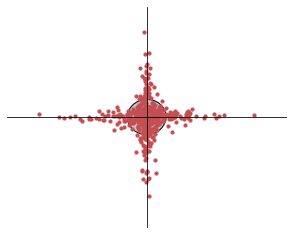

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(wi_ctx1, wi_ctx2, color=color, s=10)
ax.set_aspect(1)
helpers.center_axes(ax)

xlim = 1.3 * max(-np.min(wi_ctx1), np.max(wi_ctx1))
ylim = 1.3 * np.max(wi_ctx2)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

X = np.array([wi_ctx1, wi_ctx2]).T
cov = X.T @ X / X.shape[0]
eigvals, eigvecs = np.linalg.eig(cov)
v1 = eigvecs[:, 0]
angle = np.arctan(v1[1] / v1[0])
angle = angle * 180 / np.pi
std_factor = 1
ax.add_artist(Ellipse(xy=[0, 0], 
                      angle=angle,
                      width=np.sqrt(eigvals[0]) * 2 * std_factor, 
                      height=np.sqrt(eigvals[1]) * 2 * std_factor, 
                      fill=True, fc='silver', ec='black', lw=1, zorder=-1))


# plt.savefig('figure_1/mante_loadings_scatter.svg', bbox_inches='tight')

# Resampling

In [18]:
net2 = clustering.to_support_net(net, np.zeros(hidden_size))
net2.resample_basis()
loss, acc = mante.test_mante(net2, x_val, y_val, mask_val)
print(loss, acc)

0.7016754746437073 0.7350000143051147


In [19]:
m_res = net2.m.detach().numpy().squeeze()
n_res = net2.n.detach().numpy().squeeze()
wi_ctx1_res = net2.wi[2].detach().numpy().squeeze()
wi_ctx2_res = net2.wi[3].detach().numpy().squeeze()
wi1_res = net2.wi[0].detach().numpy().squeeze()
wi2_res = net2.wi[1].detach().numpy().squeeze()

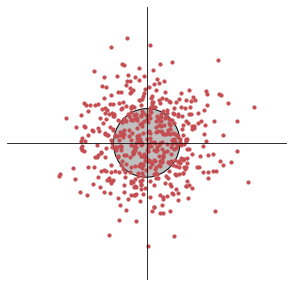

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(wi_ctx1_res, wi_ctx2_res, s=10, color=color)
helpers.center_axes(ax)
xlim = 1.3 * max(-np.min(wi_ctx1_res), np.max(wi_ctx1_res))
ylim = 1.3 * max(-np.min(wi_ctx2_res), np.max(wi_ctx2_res))
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

X = np.array([wi_ctx1, wi_ctx2]).T
cov = X.T @ X / X.shape[0]
eigvals, eigvecs = np.linalg.eig(cov)
v1 = eigvecs[:, 0]
angle = np.arctan(v1[1] / v1[0])
angle = angle * 180 / np.pi
std_factor = 1
ax.add_artist(Ellipse(xy=[0, 0], 
                      angle=angle,
                      width=np.sqrt(eigvals[0]) * 2 * std_factor, 
                      height=np.sqrt(eigvals[1]) * 2 * std_factor, 
                      fill=True, fc='silver', ec='black', lw=1, zorder=-1))

# plt.savefig('figure_1/mante_res_scatter.svg', bbox_inches='tight')

(500, 512)
clusteriness: -0.05242943502448182
data mean: 0.460, mc mean: 0.456
KS 2 sample test: p=0.5083433441048566
Wilcoxon rank-sum test: p=0.4248947480200902
Kruskal-Wallis test: p=0.42489474785681647


(0.4248947480200902, -0.05242943502448182)

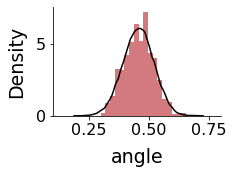

In [21]:
figsize = plt.rcParams['figure.figsize']
figsize = (figsize[0] / 2, figsize[1] / 2)
conn_space = np.array([wi1_res, wi2_res, wi_ctx1_res, wi_ctx2_res, m_res, n_res]).T
ms.epairs(conn_space, 500, figsize=figsize, xlim=(.1, .8), col=color)
# plt.savefig('figure_1/epairs_mante_res.pdf', bbox_inches='tight')